# Задание № 1. Визуализация деревьев

Реализуем алгоритм Layered-Tree-Draw.

Импортируем библиотеке - **networkx** для работы с графом, **matplotlib** - для отрисовки графа.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

Загрузим тестовое дерево

In [2]:
!wget https://github.com/Zetman13/DataVizualizationMethods/raw/master/task1/tree1.xml -O tree.xml

--2021-03-28 12:37:08--  https://github.com/Zetman13/DataVizualizationMethods/raw/master/task1/tree1.xml
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Zetman13/DataVizualizationMethods/master/task1/tree1.xml [following]
--2021-03-28 12:37:08--  https://raw.githubusercontent.com/Zetman13/DataVizualizationMethods/master/task1/tree1.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3669 (3.6K) [text/plain]
Saving to: ‘tree.xml’

tree.xml            100%[===================>]   3.58K  --.-KB/s    in 0s      

2021-03-28 12:37:08 (38.2 MB/s) - ‘tree.xml’ saved [3669/3669]



Создадим класс для удобства работы. Подробности прокомментированы в коде класса.

In [3]:
class Tree:
    def __init__(self, path):
        self.G = nx.read_graphml(path)  # Считываем дерево - ориентированный граф
        self.root = self.find_root()  # Находим корень

    def find_root(self):
        """Находит корень дерева
        """
        # Если в вершину не входит ни одно ребро - она является корнем дерева
        for node, in_degree in self.G.in_degree():
            if in_degree == 0:
                return node

    def __compute_coord(self, root, x_curr, y_curr):
        """Вычисляет координаты вершин поддерева с корнем в вершине root так, чтобы:
        соседи [0, num_neighbors // 2) были слева от корня поддерева,
        соседи [num_neighbors // 2, num_neighbors) - справа от корня поддерева
        :param root: Корень поддерева
        :type root: str
        :param x_curr: Координата x, с которой начнется вычисление координат
        :type x_curr: int
        :param y_curr: Координата y, с которой начнется вычисление координат
        :type y_curr: int
        """
        # Находим дочерние вершины корня поддерева
        neighbors = [node for node in self.G.neighbors(root)]
        num_neighbors = len(neighbors)

        # Вычисляем координаты для левых дочерних поддеревьев
        for neighbor in neighbors[:num_neighbors // 2]:
            x_curr = self.__compute_coord(neighbor, x_curr, y_curr+1)

        # Вычисляем координаты корня поддерева
        self.G.nodes[root]['x'] = x_curr
        self.G.nodes[root]['y'] = y_curr
        if num_neighbors != 1:
            x_curr += 1

        # Вычисляем координаты для правых дочерних поддеревьев
        for neighbor in neighbors[num_neighbors // 2:]:
            x_curr = self.__compute_coord(neighbor, x_curr, y_curr+1)

        return x_curr

    def __compute_sillouete(self, root):
        """Вычисляет силует поддерева с корнем в вершине root
        :param root: Корень поддерева
        :type root: str
        """
        # Находим дочерние вершины корня поддерева
        neighbors = [node for node in self.G.neighbors(root)]
        num_neighbors = len(neighbors)

        # Если дочерных вершин нет, то силуэт задается координатами самого корня
        if num_neighbors == 0:
            self.G.nodes[root]['sillouete'] = [
                [self.G.nodes[root]['x'], self.G.nodes[root]['x']]
            ]
        # Если дочерняя вершина одна, то силуэт продлевается координатами самого корня
        elif num_neighbors == 1:
            self.__compute_sillouete(neighbors[0])
            self.G.nodes[root]['sillouete'] = [[self.G.nodes[root]['x'], self.G.nodes[root]['x']]] + self.G.nodes[neighbors[0]]['sillouete']
        else:
        # Если дочерных вершин несколько, то считаем силует всех поддеревьев и дополняем его координатами самого корня
            for n in neighbors:
                self.__compute_sillouete(n)
            self.G.nodes[root]['sillouete'] = [[self.G.nodes[root]['x'], self.G.nodes[root]['x']]]
            depths = [len(self.G.nodes[n]['sillouete']) for n in neighbors]
            for y in range(max(depths)):
                lefts = []
                rights = []
                for n in neighbors:
                    n_sil = self.G.nodes[n]['sillouete']
                    try:
                        lefts.append(n_sil[y][0])
                        rights.append(n_sil[y][1])
                    except IndexError:
                        pass
                left = min(lefts)
                right = max(rights)
                self.G.nodes[root]['sillouete'] = self.G.nodes[root]['sillouete'] + [[left, right]]
        
    def __fix_coords(self, root):
        """Сжимает поддерево с корнем в вершине root
        :param root: Корень поддерева
        :type root: str
        """
        # Находим дочерние вершины корня поддерева
        neighbors = [node for node in self.G.neighbors(root)]
        num_neighbors = len(neighbors)

        # Смещаем координаты для всех дочерних поддеревьев
        for n in neighbors:
            self.__fix_coords(n)

        # Если дочерних вершин нет, то ничего не делаем
        if num_neighbors == 0:
            return None
        # Если дочерних вершин как минимум две, то выполняем сдвиг для каждого поддерева, корнем которого является дочерняя вершина
        elif num_neighbors >= 2:
            for i in range(1, num_neighbors):  # Первую вершину не сдвигаем, с ней все хорошо
                n2 = neighbors[i]
                dists = []  # Находим максимально возможную дистанцию, на которую можно сдвинуть поддерево с корнем в n2, чтобы не было наложения вершин
                for j in range(0, i):
                    n1 = neighbors[j]
                    dists.append(self.__calc_dist(n1, n2))
                dist = min(dists)
                self.__shift_subtree(n2, - (dist - 1))  # Выполняем сдвиг
                self.__compute_sillouete(n2)  # Пересчитываем силуэт поддерева n2
        self.G.nodes[root]['x'] = sum([self.G.nodes[n]['x'] for n in neighbors]) // num_neighbors  # Обновляем координату корня
        self.__compute_sillouete(root)  # Пересчитываем силуэт основного поддерева
    
    def __calc_dist(self, n1, n2):
        """Вычисляет расстояние между двумя поддеревьями с общим предком с корнями в вершинах
        :param n1: Корень левого поддерева
        :type n1: str
        :param n2: Корень правого поддерева
        :type n2: str
        """
        s1 = self.G.nodes[n1]['sillouete']
        s2 = self.G.nodes[n2]['sillouete']
        dists = []
        for y in range(max(len(s1), len(s2))):
            try:
                dists.append(s2[y][0] - s1[y][1])
            except IndexError:
                pass
        return min(dists)

    def __shift_subtree(self, root, shift):
        """Сдвигает поддерево с корнем root на shift вправо
        :param root: Корень поддерева
        :type root: str
        :param shift: Величина сдвига
        :type shift: float
        """
        self.G.nodes[root]['x'] += shift
        for n in self.G.neighbors(root):
            self.__shift_subtree(n, shift)
                   

    def plot_graph(self, condensed=True, save=True, save_path='result.svg'):
        """Строит визуализацию дерева
        :param condensed: Следует ли сжать координаты вершин дерева
        :type condensed: bool
        :param save: Следует ли сохранить визуализацию дерева в файл
        :type save: bool
        :param save_path: Путь для сохранения визуализации дерева
        :type save_path: str
        """
        self.__compute_coord(self.root, x_curr=0, y_curr=0)
        self.__compute_sillouete(self.root)
        if condensed:
            self.__fix_coords(self.root)

        x_arr = [self.G.nodes[node]['x'] for node in self.G.nodes]
        y_arr = [self.G.nodes[node]['y'] for node in self.G.nodes]

        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111)
        for start in self.G.nodes:
            for end in self.G.neighbors(start):
                x1 = self.G.nodes[start]['x']
                y1 = self.G.nodes[start]['y']
                x2 = self.G.nodes[end]['x']
                y2 = self.G.nodes[end]['y']

                ax.plot([x1,x2], [y1,y2],linestyle='-', marker='o', ms=10, markerfacecolor='blue', color='black')     

        plt.gca().invert_yaxis()
        plt.axis('off')
        plt.show()

        fig.savefig('result.svg')

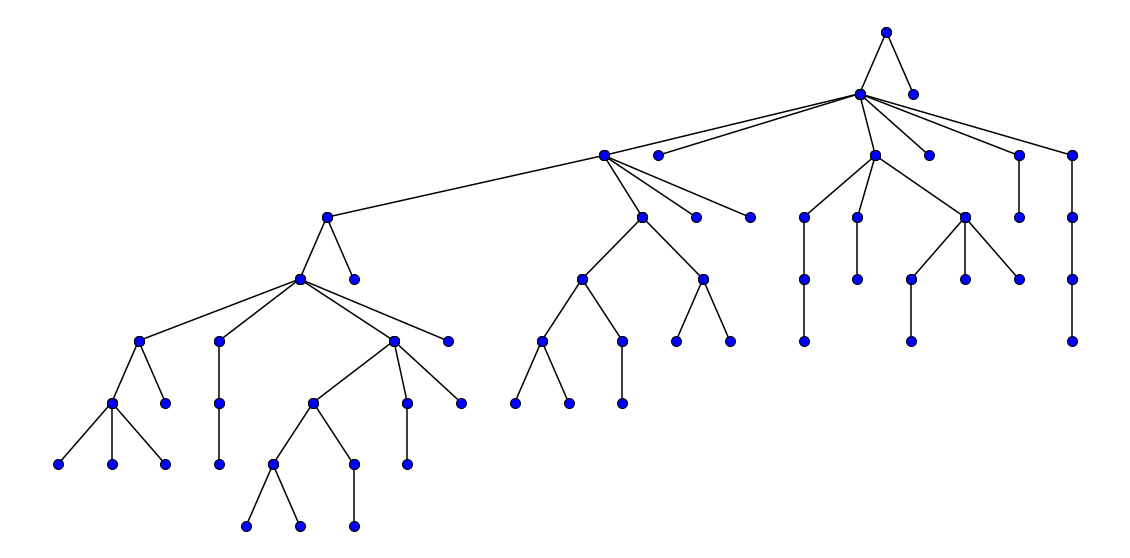

In [4]:
tree = Tree('tree.xml')
tree.plot_graph(condensed=True, save=True, save_path='result.svg')